https://notebook.community/google/eng-edu/ml/pc/exercises/image_classification_part3

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-05-02 23:11:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.25.176, 142.250.76.144, 142.250.206.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.25.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

/tmp/inception_v3_w 100%[===================>]  83.84M  11.0MB/s    in 7.4s    

2023-05-02 23:11:14 (11.3 MB/s) - '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [4]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [6]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [7]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2023-05-02 13:41:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 142.251.163.128, 142.251.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   162MB/s    in 0.4s    

2023-05-02 13:41:08 (162 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

<ipython-input-9-223274cfaaff>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
100/100 - 32s - loss: 0.9177 - acc: 0.8320 - val_loss: 0.1552 - val_acc: 0.9390 - 32s/epoch - 316ms/step
Epoch 2/2
100/100 - 18s - loss: 0.2526 - acc: 0.9045 - val_loss: 0.0989 - val_acc: 0.9590 - 18s/epoch - 183ms/step


In [10]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50


<ipython-input-11-cc858d536531>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 33s - loss: 0.2183 - acc: 0.9130 - val_loss: 0.1580 - val_acc: 0.9460 - 33s/epoch - 331ms/step
Epoch 2/50
100/100 - 19s - loss: 0.1651 - acc: 0.9330 - val_loss: 0.1891 - val_acc: 0.9410 - 19s/epoch - 185ms/step
Epoch 3/50
100/100 - 20s - loss: 0.1534 - acc: 0.9340 - val_loss: 0.0919 - val_acc: 0.9600 - 20s/epoch - 197ms/step
Epoch 4/50
100/100 - 19s - loss: 0.1163 - acc: 0.9500 - val_loss: 0.0850 - val_acc: 0.9730 - 19s/epoch - 190ms/step
Epoch 5/50
100/100 - 19s - loss: 0.1158 - acc: 0.9590 - val_loss: 0.0917 - val_acc: 0.9650 - 19s/epoch - 187ms/step
Epoch 6/50
100/100 - 20s - loss: 0.1123 - acc: 0.9590 - val_loss: 0.1558 - val_acc: 0.9470 - 20s/epoch - 195ms/step
Epoch 7/50
100/100 - 19s - loss: 0.0994 - acc: 0.9595 - val_loss: 0.0928 - val_acc: 0.9660 - 19s/epoch - 186ms/step
Epoch 8/50
100/100 - 19s - loss: 0.0809 - acc: 0.9735 - val_loss: 0.1569 - val_acc: 0.9530 - 19s/epoch - 194ms/step
Epoch 9/50
100/100 - 19s - loss: 0.0844 - acc: 0.9705 - val_loss: 0.0815 - val_acc:

Text(0.5, 1.0, 'Training and validation loss')

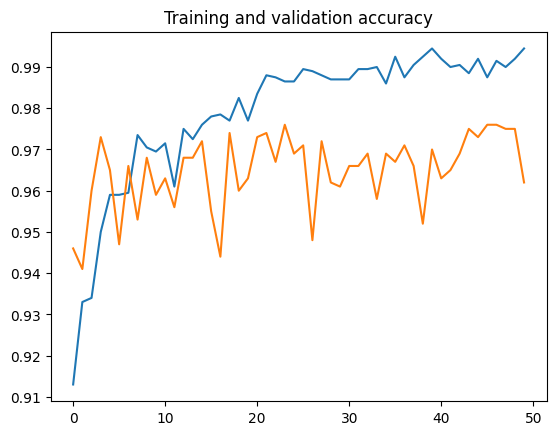

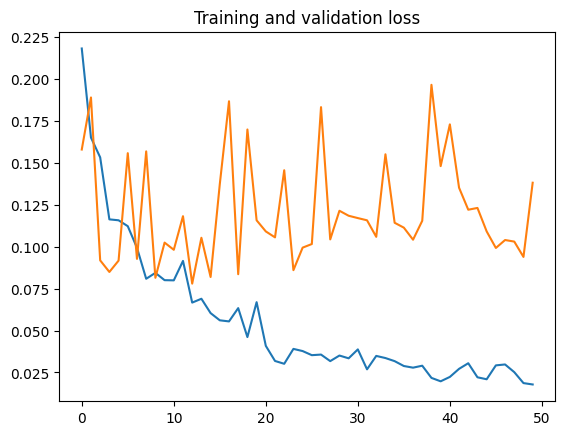

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [14]:
import numpy as np
from google.colab import files
#from keras.preprocessing import image
import keras.utils as image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 01_beautiful-maine-coon-cat-young.jpg to 01_beautiful-maine-coon-cat-young (1).jpg
Saving 1.jpg to 1 (1).jpg
Saving 100.jpg to 100 (1).jpg
Saving 20230221-10036196-it_nlab-000-1-view.jpg to 20230221-10036196-it_nlab-000-1-view (1).jpg
Saving GettyImages-1040920528-scaled.jpg to GettyImages-1040920528-scaled (1).jpg
Saving img_afa0fad37e6c4d5ce34c01faf54f9e79108563.jpg to img_afa0fad37e6c4d5ce34c01faf54f9e79108563 (1).jpg
Saving mainecoon_1-740x429.jpg to mainecoon_1-740x429 (1).jpg
Saving wolf-2826741__480.jpg to wolf-2826741__480 (1).jpg
Saving Wolf.jpg to Wolf (1).jpg
1/1 [==============================] - 2s 2s/step
[[1.]]
[1.]
01_beautiful-maine-coon-cat-young.jpg is a dog
1/1 [==============================] - 0s 24ms/step
[[0.01182911]]
[0.01182911]
1.jpg is a cat
1/1 [==============================] - 0s 23ms/step
[[2.8189392e-32]]
[2.8189392e-32]
100.jpg is a cat
1/1 [==============================] - 0s 28ms/step
[[0.]]
[0.]
20230221-10036196-it_nlab-000-1-view.jpg is a